# Tests with DeepKnockofs

In [243]:
import scipy.io
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.cluster.hierarchy as spc
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)


In [235]:
from input_output import load
from deepknockoffs.examples import data
from deepknockoffs.examples import parameters

from DeepKnockoffs import KnockoffMachine
from DeepKnockoffs import GaussianKnockoffs

from sklearn.model_selection import train_test_split

In [76]:
# load the data
hrf = load.load_hrf_function()
fMRI = load.load_hrf(task='MOTOR')
task_paradigms = load.load_task_paradigms('MOTOR')

Loaded HRF and padded with 10 0's- Length: 65
Loaded Data - Shape: (100, 379, 284)
Loaded Task Paradigms - Length: 100


In [220]:
# I take the first subject (for tests)
fMRI0=fMRI[0,:,:]

## 1. Preprocessing

### Compute correlations

Extremely correlated variables would result in knockoffs having no power.

In [221]:
# Compute covariance matrix
SigmaHat = np.cov(fMRI0)
# Compute correlation matrix
SigmaHat = data.cov2cor(SigmaHat)
SigmaHat.shape

(379, 379)

<AxesSubplot:>

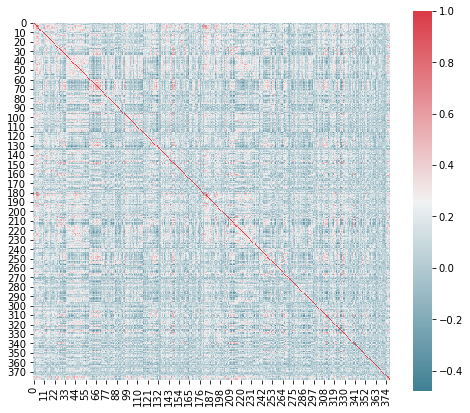

In [222]:
### Viewing in a heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(SigmaHat, cmap=cmap, square=True)

### Hierarchical clustering

We apply hierarchical clustering to the correlation matrix. In this case, we choose average-linkage clustering, although other options may be better suited in different scenarios.

In [223]:
# Compute distance between variables based on their pairwise absolute correlations
pdist = spc.distance.squareform(1-np.abs(SigmaHat))

# Apply average-linkage hierarchical clustering
linkage = spc.linkage(pdist, method='average')

print('covariance: {}, pairwise absolute correlations: {}, average-linkage: {}'.format(SigmaHat.shape, pdist.shape, linkage.shape))

covariance: (379, 379), pairwise absolute correlations: (71631,), average-linkage: (378, 4)


In [224]:
linkage

array([[0.00000000e+00, 1.80000000e+02, 1.49524867e-01, 2.00000000e+00],
       [3.00000000e+00, 4.00000000e+00, 2.18892160e-01, 2.00000000e+00],
       [1.47000000e+02, 3.27000000e+02, 2.26147584e-01, 2.00000000e+00],
       ...,
       [7.47000000e+02, 7.53000000e+02, 9.32452465e-01, 3.75000000e+02],
       [7.30000000e+02, 7.54000000e+02, 9.32746923e-01, 3.78000000e+02],
       [3.66000000e+02, 7.55000000e+02, 9.42979950e-01, 3.79000000e+02]])

Next, we group the variables into highly-correlated blocks and keep only one representative from each blocks.
To ensure that the typical remaining correlations are below the (arbitrary) target level ($\rho_\max=0.7$), we cut the dendrogram at height $d_\max=1- \rho_\max=0.3$.

In [225]:
corr_max = 0.2
d_max = 1-corr_max

Let's now plot the clustering dendrogram and visualize the groups corresponding to the cut defined above.

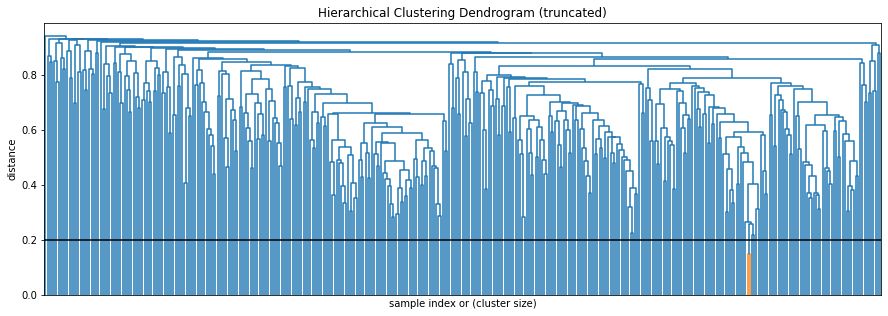

In [226]:
def fancy_dendrogram(*args, **kwargs):
    """From: 
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = spc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))

# Plot dendrogram
fancy_dendrogram(
    linkage,
    max_d=1-d_max,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    no_labels=True,
)
plt.show()

Let's now extract the groups shown above.

In [227]:
# Cut the dendrogram and define the groups of variables
groups = spc.cut_tree(linkage, height=d_max).flatten()
print("Divided " + str(len(groups)) + " variables into "+str(np.max(groups)+1) + " groups.")

# Plot group sizes
_, counts = np.unique(groups, return_counts=True)
print("Size of largest groups: "+str(np.max(counts)))
print("Mean groups size: "+str(np.mean(counts)))

Divided 379 variables into 68 groups.
Size of largest groups: 93
Mean groups size: 5.573529411764706


### Pick group representatives

The final pre-processing step is to pick one variable as representative from each group. For simplicity, here we pick the first variable in each group (in the arbitrary order defined by the the "groups" vector).

In [228]:
# Pick one representative for each cluster
representatives = np.array([np.where(groups==g)[0][0] for g in np.arange(np.max(groups))])
# Print list of group representatives
representatives

array([  0,   1,   7,  11,  13,  18,  28,  31,  56,  63,  78,  79,  81,
        84,  89,  91, 103, 106, 109, 111, 113, 117, 122, 126, 128, 133,
       134, 140, 159, 163, 165, 172, 181, 190, 199, 201, 203, 221, 237,
       243, 258, 260, 262, 272, 277, 280, 282, 285, 286, 289, 290, 299,
       301, 305, 306, 313, 314, 333, 343, 347, 351, 363, 365, 366, 368,
       371, 372])

Now we can measure the remaining correlations among the group representatives

In [229]:
# Correlation matrix for group representatives
SigmaHat_repr = SigmaHat[representatives,:][:,representatives]

# Print largest remaining correlation
np.max(np.abs(SigmaHat_repr-np.eye(SigmaHat_repr.shape[0])))

0.4076450831014804

<AxesSubplot:>

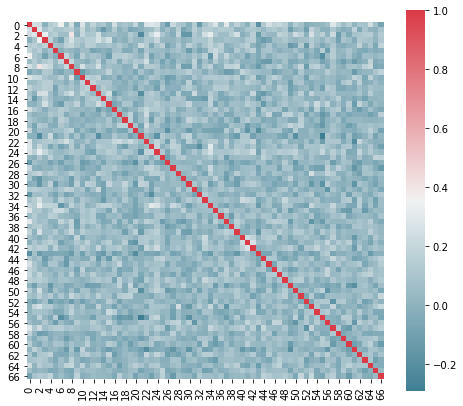

In [230]:
### Correlation matrix for the group representatives

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Draw the heatmap
sns.heatmap(SigmaHat_repr, cmap=cmap, square=True)

In [231]:
fMRI[0,:,:]
fMRI.shape
representatives
fMRI[0,representatives,:].shape
np.mean(fMRI[0,representatives,:], 1).shape
fMRI_repr = fMRI[0, representatives, :]
print(fMRI_repr.shape)
print(np.mean(fMRI[0,representatives,:], 1).shape)

(67, 284)
(67,)


We can see that our data is not correlated (at least for the first subject).

## 2. Deep Knockoffs

### Second-order knockoffs

After computing the empirical covariance matrix of $X$ in the training dataset, we can initialize a generator of second-order knockoffs. The solution of the SDP determines the pairwise correlations between the original variables and the knockoffs produced by this algorithm.

In [232]:
# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(fMRI[0,representatives,:])
print(SigmaHat.shape)

# Initialize generator of second-order knockoffs --> I am using SigmaHat_repr
mu = np.mean(fMRI[0,representatives,:], 1)
second_order = GaussianKnockoffs(SigmaHat, mu=mu, method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

(67, 67)
Average absolute pairwise correlation: 0.494.


In [233]:
second_order.Ds # diagonals

array([[5.29517306e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.15056920e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.85729709e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.25078945e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.74702848e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.03741945e-01]])

In [266]:
# Training data
fMRI_repr = fMRI[:,representatives,:]  # taking only representatives of features
idx = random.sample(range(fMRI_repr.shape[0]), k=80)
X_train = fMRI_repr[idx, :, :]
print("Generated a training dataset of size: ", (X_train.shape))

# Generate second-order knockoffs
Xk_train_g = second_order.generate(X_train)
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Generated a training dataset of size:  (80, 67, 284)


ValueError: too many values to unpack (expected 2)

In [264]:
X_train.shape

(80, 67, 284)